In [34]:
#!pip install --upgrade gym
#!pip install --upgrade gym-notices

Defaulting to user installation because normal site-packages is not writeable


In [1]:
import gym
import numpy as np
from collections import deque
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = (16, 10)

from tqdm import tqdm

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.distributions import Categorical
torch.manual_seed(0)

import base64, io

# For visualization
from gym.wrappers.monitoring import video_recorder
from IPython.display import HTML
from IPython import display
import glob

device = torch.device("mps" if torch.backends.mps.is_available() else
                      "cuda:0" if torch.cuda.is_available() else
                      "cpu")
device

env = gym.make('CartPole-v0')
#env.seed(0)

/Users/alan/Library/Python/3.9/lib/python/site-packages/gym/envs/registration.py:555: UserWarning: WARN: The environment CartPole-v0 is out of date. You should consider upgrading to version `v1`.
  logger.warn(


### Define Policy
Unlike value-based method, the output of policy-based method is the probability of each action. It can be represented as policy. So activation function of output layer will be softmax, not ReLU.

In [3]:
class Actor(nn.Module):
    def __init__(self, state_size=4, action_size=2, hidden_size=32):
        super(Policy, self).__init__()
        self.fc1 = nn.Linear(state_size, hidden_size)
        self.fc2 = nn.Linear(hidden_size, action_size)

    def forward(self, state):
        x = F.relu(self.fc1(state))
        x = self.fc2(x)
        # we just consider 1 dimensional probability of action
        return F.softmax(x, dim=1)

    def act(self, state):
        state = torch.from_numpy(state).float().unsqueeze(0)
        probs = self.forward(state).cpu()
        model = Categorical(probs)
        action = model.sample()
        return action.item(), model.log_prob(action)

In [4]:
class Critic(nn.Module):
    def __init__(self, state_size=4, action_size=2, hidden_size=32):
        super(Policy, self).__init__()
        self.fc1 = nn.Linear(state_size + action_size, hidden_size)
        self.fc2 = nn.Linear(hidden_size, 1)

    def forward(self, state):
        x = torch.cat([state, action], dim=1)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        # we just consider 1 dimensional probability of action
        return x

    def act(self, state):
        state = torch.from_numpy(state).float().unsqueeze(0)
        probs = self.forward(state).cpu()
        model = Categorical(probs)
        action = model.sample()
        return action.item(), model.log_prob(action)

### SAC

In [5]:
def sac(policy, optimizer, early_stop, n_episode):
    state_old = env.reset()
    buffer = []
    action, _ = policy.act(state_old)
    state, reward, done, _ = env.step(action)
    buffer.append({"s" : state_old,
                   "a" : action,
                   "r" : reward,
                   "sprime" : state,
                   "done" : done})

    if done:
        env.reset()

In [17]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import gym

# Define the actor network
class Actor(nn.Module):
    def __init__(self, state_dim, action_dim, hidden_dim=256):
        super(Actor, self).__init__()
        self.fc1 = nn.Linear(state_dim, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, hidden_dim)
        self.fc3 = nn.Linear(hidden_dim, action_dim)

    def forward(self, state):
        x = F.relu(self.fc1(state))
        x = F.relu(self.fc2(x))
        x = torch.tanh(self.fc3(x))
        return x

# Define the critic network
class Critic(nn.Module):
    def __init__(self, state_dim, action_dim, hidden_dim=256):
        super(Critic, self).__init__()
        self.fc1 = nn.Linear(state_dim + action_dim, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, hidden_dim)
        self.fc3 = nn.Linear(hidden_dim, 1)

    def forward(self, state, action):
        
        x = torch.cat([state.squeeze(), action], dim=1)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)

        return x

# Define the soft Q-function network
class SoftQNetwork(nn.Module):
    def __init__(self, state_dim, action_dim, hidden_dim=256):
        super(SoftQNetwork, self).__init__()
        self.fc1 = nn.Linear(state_dim + action_dim, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, hidden_dim)
        self.fc3 = nn.Linear(hidden_dim, 1)

    def forward(self, state, action):
        x = torch.cat([state, action], dim=1)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

# Define the Soft Actor-Critic agent
class SACAgent:
    def __init__(self, state_dim, action_dim, device="cpu", hidden_dim=256, lr=3e-4):
        self.actor = Actor(state_dim, action_dim, hidden_dim)
        self.critic1 = Critic(state_dim, action_dim, hidden_dim)
        self.critic2 = Critic(state_dim, action_dim, hidden_dim)
        self.target_critic1 = Critic(state_dim, action_dim, hidden_dim)
        self.target_critic2 = Critic(state_dim, action_dim, hidden_dim)
        self.soft_q_network = SoftQNetwork(state_dim, action_dim, hidden_dim)

        self.target_critic1.load_state_dict(self.critic1.state_dict())
        self.target_critic2.load_state_dict(self.critic2.state_dict())

        self.actor_optimizer = optim.Adam(self.actor.parameters(), lr=lr)
        self.critic1_optimizer = optim.Adam(self.critic1.parameters(), lr=lr)
        self.critic2_optimizer = optim.Adam(self.critic2.parameters(), lr=lr)
        self.soft_q_network_optimizer = optim.Adam(self.soft_q_network.parameters(), lr=lr)

    def select_action(self, state):

        with torch.no_grad():
            action = self.actor(state)

        action_probs = F.softmax(action).detach().numpy() 

        return action_probs
    
    def train(self, replay_buffer, batch_size=128, gamma=0.99, alpha=0.2):
        state_batch, action_batch, reward_batch, next_state_batch, done_batch = replay_buffer.sample(batch_size)
        #print("batch",action_batch)
        state_batch = torch.FloatTensor(state_batch)
        action_batch = torch.FloatTensor(action_batch)
        reward_batch = torch.FloatTensor(reward_batch).unsqueeze(1)
        next_state_batch = torch.FloatTensor(next_state_batch)
        done_batch = torch.FloatTensor(np.float32(done_batch)).unsqueeze(1)

        # Update Q-networks
        with torch.no_grad():
            next_actions = self.actor(next_state_batch)

            next_actions_prob = F.softmax(next_actions, dim=1).detach()

            next_q_values1 = self.target_critic1(next_state_batch, next_actions_prob)
            next_q_values2 = self.target_critic2(next_state_batch, next_actions_prob)

            next_actions = np.zeros(len(next_actions_prob[:,0]))
            for i in range(len(next_actions_prob[:,0])):
                next_actions[i] = np.argmax(np.random.multinomial(1, next_actions_prob[i,:]))
            next_q_values = torch.min(next_q_values1, next_q_values2).squeeze() - alpha * torch.log(torch.FloatTensor(next_actions))

            expected_q_values = (reward_batch.squeeze() + gamma * (1 - done_batch.squeeze()) * next_q_values).unsqueeze(1)

        q1 = self.critic1(state_batch, action_batch)
        q2 = self.critic2(state_batch, action_batch)

        critic1_loss = F.mse_loss(q1, expected_q_values)
        critic2_loss = F.mse_loss(q2, expected_q_values)

        self.critic1_optimizer.zero_grad()
        critic1_loss.backward()
        self.critic1_optimizer.step()

        self.critic2_optimizer.zero_grad()
        critic2_loss.backward()
        self.critic2_optimizer.step()

        # Update actor
        actions = self.actor(state_batch)
        actor_loss = (alpha * torch.log(actions) - self.soft_q_network(state_batch, actions)).mean()

        self.actor_optimizer.zero_grad()
        actor_loss.backward()
        self.actor_optimizer.step()

        # Update target networks
        for target_param, param in zip(self.target_critic1.parameters(), self.critic1.parameters()):
            target_param.data.copy_(0.995 * target_param.data + 0.005 * param.data)

        for target_param, param in zip(self.target_critic2.parameters(), self.critic2.parameters()):
            target_param.data.copy_(0.995 * target_param.data + 0.005 * param.data)

# Initialize environment
env = gym.make('CartPole-v1')
state_dim = env.observation_space.shape[0]
action_dim = env.action_space.shape[0] if isinstance(env.action_space, gym.spaces.Box) else env.action_space.n
# Initialize agent
device = torch.device("cpu")
agent = SACAgent(state_dim, action_dim, device)

# Initialize replay buffer
class ReplayBuffer:
    def __init__(self, max_size=10000):
        self.storage = []
        self.max_size = max_size
        self.ptr = 0
        self.size = 0
        self.size_flag = True

    def add(self, transition):
        if self.ptr == self.max_size - 1:
            self.size_flag = False
            self.size = self.max_size - 1 
            self.ptr = 0
            self.storage[int(self.ptr)] = transition
            
        else:
            if self.size_flag == True:
                self.size += 1
            self.ptr += 1
            self.storage.append(transition)

    def sample(self, batch_size):
        ind = np.random.randint(0, self.size, size=batch_size)
        #print(len(self.storage),self.ptr,ind)
        states, actions, rewards, next_states, dones = [], [], [], [], []
        for i in ind:
            s, a, r, s_, d = self.storage[i]
            states.append(np.array(s, copy=False))
            actions.append(np.array(a, copy=False))
            rewards.append(np.array(r, copy=False))
            next_states.append(np.array(s_, copy=False))
            dones.append(np.array(d, copy=False))

        return np.array(states), np.array(actions), np.array(rewards), np.array(next_states), np.array(dones)

# Training loop
n_episodes = 1000
replay_buffer = ReplayBuffer()
rewards = []
progress_bar = tqdm(total=n_episodes)

for _ in range(n_episodes):  # Run for 1000 episodes
    state = env.reset()
    state = torch.FloatTensor(state[0])#.unsqueeze(0)
    episode_reward = 0
    done = False
    while not done:
        action = agent.select_action(state)
        #print(action)
        next_state, reward, done, _, _ = env.step(np.random.choice(len(action), p=action))

        replay_buffer.add((state, action, reward, next_state, done))
        episode_reward += reward
        state = torch.FloatTensor(next_state)#.unsqueeze(0)

        if len(replay_buffer.storage) > 128:
            agent.train(replay_buffer)
    progress_bar.update(1)
    rewards.append(episode_reward)
    #print("Episode Reward:", episode_reward)

env.close()


  0%|          | 0/1000 [00:18<?, ?it/s]


/var/folders/55/6_49hd192z5c33kgxtpcm_040000gn/T/ipykernel_91918/2765191910.py:77: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  action_probs = F.softmax(action).detach().numpy()
/Users/alan/Library/Python/3.9/lib/python/site-packages/gym/utils/passive_env_checker.py:233: DeprecationWarning: `np.bool8` is a deprecated alias for `np.bool_`.  (Deprecated NumPy 1.24)
  if not isinstance(terminated, (bool, np.bool8)):
  7%|▋         | 66/1000 [00:04<01:10, 13.23it/s]

KeyboardInterrupt: 

  7%|▋         | 67/1000 [00:15<01:10, 13.23it/s]

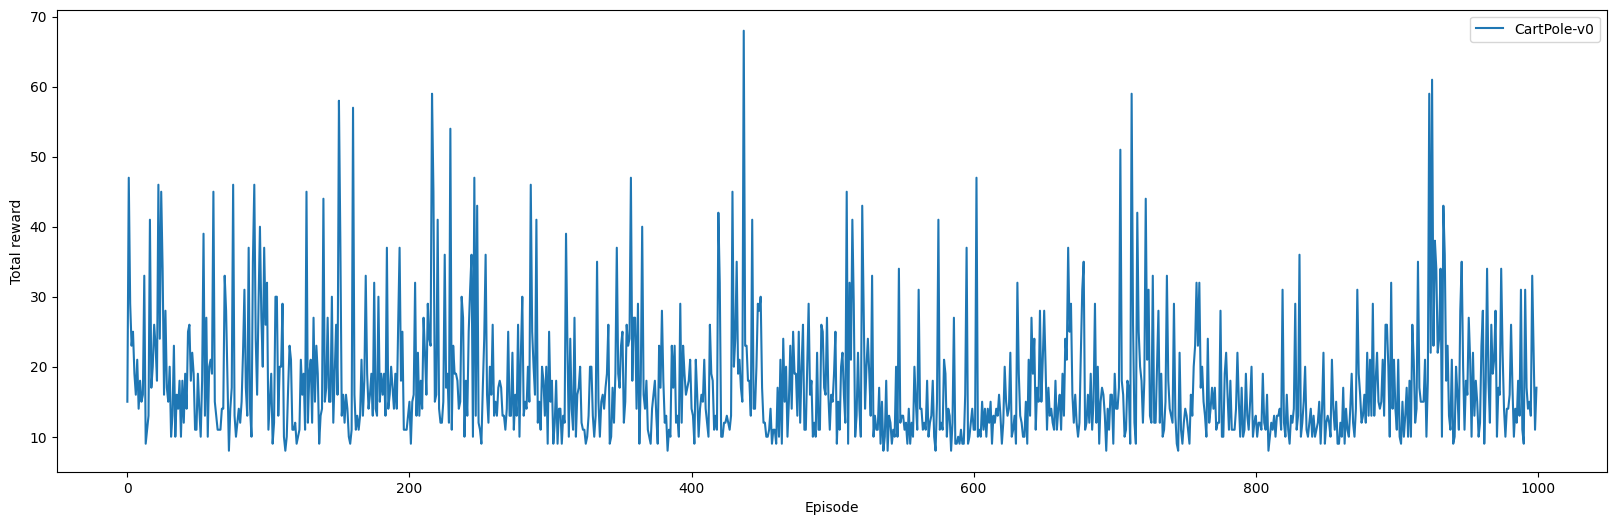

100%|██████████| 1000/1000 [01:30<00:00, 12.28it/s]

In [ ]:
plt.figure(figsize=(20,6))
plt.plot(rewards,label="CartPole-v0")
plt.xlabel("Episode")
plt.ylabel("Total reward")
plt.legend()
plt.show()

In [37]:
TAU = 0.01
LR = 3e-4
ALPHA = 0.5
GAMMA = 0.95
class Actor(nn.Module):
    def __init__(self, state_dim, action_dim, hidden_dim=256):
        super(Actor, self).__init__()
        self.fc1 = nn.Linear(state_dim, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, hidden_dim)
        self.fc3 = nn.Linear(hidden_dim, action_dim)

    def forward(self, state):
        x = F.relu(self.fc1(state))
        x = F.relu(self.fc2(x))
        logits = self.fc3(x)
        return logits


class Critic(nn.Module):
    def __init__(self, state_dim, action_dim, hidden_dim=256):
        super(Critic, self).__init__()
        self.fc1 = nn.Linear(state_dim + action_dim, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, hidden_dim)
        self.fc3 = nn.Linear(hidden_dim, 1)

    def forward(self, state, action):
        x = torch.cat([state, action], dim=1)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x


class SoftQNetwork(nn.Module):
    def __init__(self, state_dim, action_dim, hidden_dim=256):
        super(SoftQNetwork, self).__init__()
        self.fc1 = nn.Linear(state_dim + action_dim, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, hidden_dim)
        self.fc3 = nn.Linear(hidden_dim, 1)
        self.apply(init_weights)

    def forward(self, state, action):
        x = torch.cat([state, action], dim=1)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

class SACAgent:
    def __init__(self, state_dim, action_dim, device="cpu", hidden_dim=256, lr=LR):
        self.device = device
        self.actor = Actor(state_dim, action_dim, hidden_dim).to(device)
        self.critic1 = Critic(state_dim, action_dim, hidden_dim).to(device)
        self.critic2 = Critic(state_dim, action_dim, hidden_dim).to(device)
        self.target_critic1 = Critic(state_dim, action_dim, hidden_dim).to(device)
        self.target_critic2 = Critic(state_dim, action_dim, hidden_dim).to(device)

        self.target_critic1.load_state_dict(self.critic1.state_dict())
        self.target_critic2.load_state_dict(self.critic2.state_dict())

        self.actor_optimizer = optim.Adam(self.actor.parameters(), lr=lr)
        self.critic1_optimizer = optim.Adam(self.critic1.parameters(), lr=lr)
        self.critic2_optimizer = optim.Adam(self.critic2.parameters(), lr=lr)


    def select_action(self, state):
        state = state.unsqueeze(0).to(self.device)
        with torch.no_grad():
            action_logits = self.actor(state)
        action_probs = F.softmax(action_logits, dim=-1).cpu().numpy().flatten()
        action = np.random.choice(len(action_probs), p=action_probs)
        return action, action_probs


    def train(self, replay_buffer, batch_size=128, gamma=GAMMA, alpha=ALPHA):
        state_batch, action_batch, reward_batch, next_state_batch, done_batch = replay_buffer.sample(batch_size)
        state_batch = torch.FloatTensor(state_batch).to(self.device)
        action_batch = torch.LongTensor(action_batch).to(self.device)
        reward_batch = torch.FloatTensor(reward_batch).unsqueeze(1).to(self.device)
        next_state_batch = torch.FloatTensor(next_state_batch).to(self.device)
        done_batch = torch.FloatTensor(done_batch).unsqueeze(1).to(self.device)

        action_one_hot = F.one_hot(action_batch, num_classes=self.actor.fc3.out_features).float()

        with torch.no_grad():
            next_action_logits = self.actor(next_state_batch)
            next_action_probs = F.softmax(next_action_logits, dim=1)
            next_q_values1 = (next_action_probs * self.target_critic1(next_state_batch, next_action_probs)).sum(dim=1, keepdim=True)
            next_q_values2 = (next_action_probs * self.target_critic2(next_state_batch, next_action_probs)).sum(dim=1, keepdim=True)
            next_q_values = torch.min(next_q_values1, next_q_values2) - alpha * torch.sum(next_action_probs * torch.log(next_action_probs + 1e-8), dim=1, keepdim=True)
            expected_q_values = reward_batch + gamma * (1 - done_batch) * next_q_values

        q1 = self.critic1(state_batch, action_one_hot)
        q2 = self.critic2(state_batch, action_one_hot)

        critic1_loss = F.mse_loss(q1, expected_q_values)
        critic2_loss = F.mse_loss(q2, expected_q_values)

        self.critic1_optimizer.zero_grad()
        critic1_loss.backward()
        self.critic1_optimizer.step()

        self.critic2_optimizer.zero_grad()
        critic2_loss.backward()
        self.critic2_optimizer.step()

        action_logits = self.actor(state_batch)
        action_probs = F.softmax(action_logits, dim=1)
        log_action_probs = torch.log(action_probs + 1e-8)
        q_values = (action_probs * self.critic1(state_batch, action_probs)).sum(dim=1, keepdim=True)
        actor_loss = (alpha * log_action_probs - q_values).mean()

        self.actor_optimizer.zero_grad()
        actor_loss.backward()
        self.actor_optimizer.step()

        for target_param, param in zip(self.target_critic1.parameters(), self.critic1.parameters()):
            target_param.data.copy_(TAU * param.data + (1.0 - TAU) * target_param.data)
        for target_param, param in zip(self.target_critic2.parameters(), self.critic2.parameters()):
            target_param.data.copy_(TAU * param.data + (1.0 - TAU) * target_param.data)




class ReplayBuffer:
    def __init__(self, max_size=50):
        self.storage = []
        self.max_size = max_size
        self.ptr = 0

    def add(self, transition):
        if len(self.storage) < self.max_size:
            self.storage.append(transition)
        else:
            self.storage[self.ptr] = transition
        self.ptr = (self.ptr + 1) % self.max_size

    def sample(self, batch_size):
        ind = np.random.randint(0, len(self.storage), size=batch_size)
        states, actions, rewards, next_states, dones = [], [], [], [], []
        for i in ind:
            s, a, r, s_, d = self.storage[i]
            states.append(np.array(s, copy=False))
            actions.append(np.array(a, copy=False))
            rewards.append(np.array(r, copy=False))
            next_states.append(np.array(s_, copy=False))
            dones.append(np.array(d, copy=False))

        return np.array(states), np.array(actions), np.array(rewards), np.array(next_states), np.array(dones)


#new_step_api = False #Much slower with new step API
env = gym.make('MountainCar-v0')
state_dim = env.observation_space.shape[0]
action_dim = env.action_space.n

device = torch.device("cpu")
agent = SACAgent(state_dim, action_dim, device, lr=LR)

n_episodes = 500
replay_buffer = ReplayBuffer()
rewards = []
progress_bar = tqdm(total=n_episodes)

for episode in range(n_episodes):
    state = env.reset()
    state = torch.FloatTensor(state[0]).to(device)
    episode_reward = 0
    done = False
    while not done:
        action, _ = agent.select_action(state)
        next_state, reward, done, _, _ = env.step(action)
        replay_buffer.add((state.cpu().numpy(), action, reward, next_state, done))
        episode_reward += reward
        state = torch.FloatTensor(next_state).to(device)

        if len(replay_buffer.storage) > 128:
            agent.train(replay_buffer)
    progress_bar.update(1)
    rewards.append(episode_reward)
    #print(f"Episode {episode} Reward: {episode_reward}")

env.close()



 12%|█▏        | 61/500 [01:47<12:56,  1.77s/it]


100%|██████████| 500/500 [23:58<00:00,  3.04s/it]

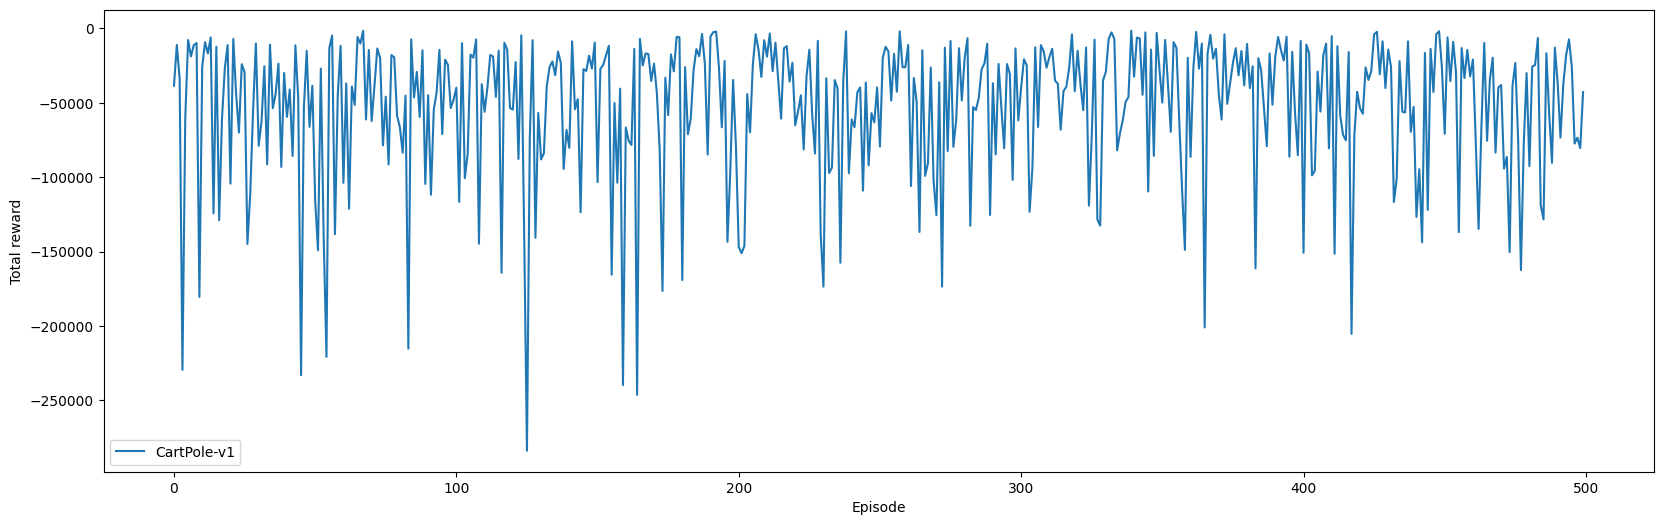

In [38]:
plt.figure(figsize=(20,6))
plt.plot(rewards,label="CartPole-v1")
plt.xlabel("Episode")
plt.ylabel("Total reward")
plt.legend()
plt.show()